# Demo for analyzing field data with NWB files

CAVEAT: I'm not actually sure if the timing of the field & spiking data lines up, so the spike-field analyses are set up as general proof-of-concept, but might not actually show anything relevant. 

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import phase_by_time, amp_by_time
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.utils import create_times

from fooof import FOOOF

from pynwb import NWBHDF5IO

In [3]:
# Define the file name of the NMB file
nwb_filename = 'nwb_local_data.nwb'

# Define the name of the relevant field data
data_field = 'field_data_1'

In [4]:
# Read in an local data NWB file
io = NWBHDF5IO(nwb_filename, 'r')
nwbfile = io.read()

### Helper Functions

In [5]:
def get_lfp_time_range(times, sig, t_range):
    """Extract a desired time range from a signal."""
    return sig[np.logical_and(times > t_range[0], times < t_range[1])]

def get_spike_time_range(spikes, tmin, tmax):
    """Extract spike times for a particular time range."""
    
    return spikes[np.squeeze(np.logical_and([spikes > tmin], [spikes < tmax]))]

### Load Field Data

In [6]:
field = 'field_data_2'

In [7]:
nwbfile.acquisition[field]

field_data_2 pynwb.ecephys.ElectricalSeries at 0x140605215923648
Fields:
  comments: ...
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1797825,), type "<f8">
  description: ...
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  rate: 500.0
  resolution: inf
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts

In [8]:
fs = nwbfile.acquisition[field].rate
print(fs)

500.0


In [9]:
field_data = nwbfile.acquisition[field].data[:]

In [10]:
n_samps = len(field_data)
time = n_samps / fs
times = create_times(time, fs)

### Check Field Data

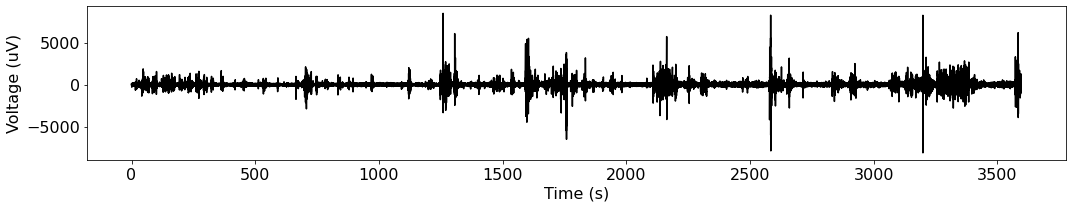

In [11]:
# Plot the full time series
plot_time_series(times, field_data)

In [12]:
freqs, powers = compute_spectrum(field_data, fs)

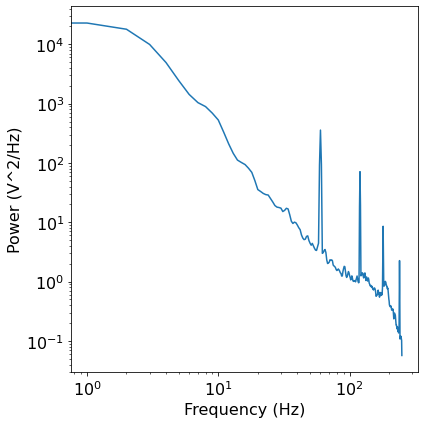

In [13]:
plot_power_spectra(freqs, powers)

9.399302572123723


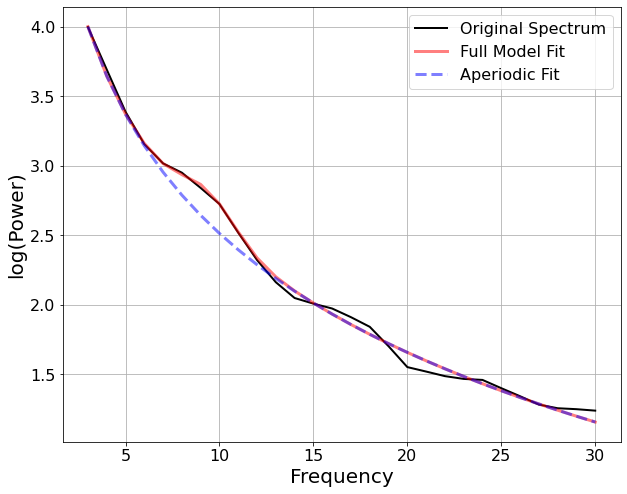

In [14]:
fm1 = FOOOF(aperiodic_mode='fixed', verbose=False)
fm1.fit(freqs, powers, [3, 30])
fm1.plot()

osc_cf = fm1.get_params('peak_params', 'CF')
print(osc_cf)

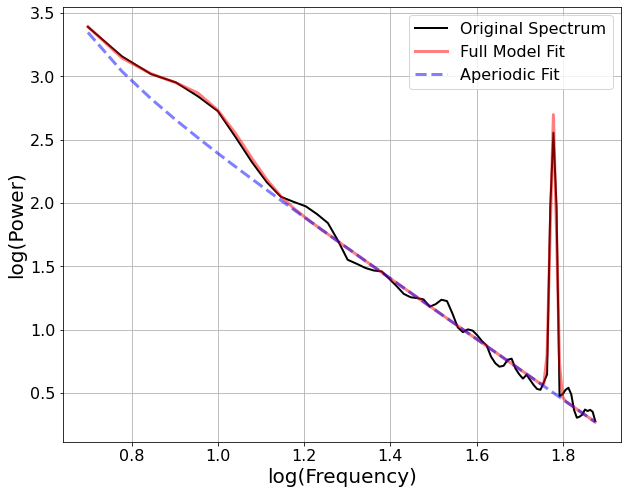

In [15]:
fm2 = FOOOF(peak_threshold=1.6,aperiodic_mode='knee', verbose=False)
fm2.fit(freqs, powers, [5, 75])
fm2.plot(plt_log=True)

### Filter and Zoom in on Field Data

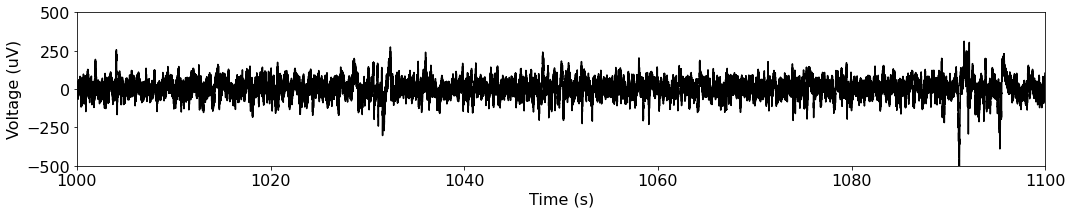

In [16]:
# Plot a zoomed in segment of data
plot_time_series(times, field_data, xlim=[1000, 1100], ylim=[-500, 500])

In [17]:
# Set filter ranges
broad_range = (1, 50)
mid_range = (osc_cf-3, osc_cf+3)
low_range = (1, 6)

# Filter data
sig_filt = filter_signal(field_data, fs, 'bandpass', broad_range)
mid_filt = filter_signal(field_data, fs, 'bandpass', mid_range)
low_filt = filter_signal(field_data, fs, 'bandpass', low_range)

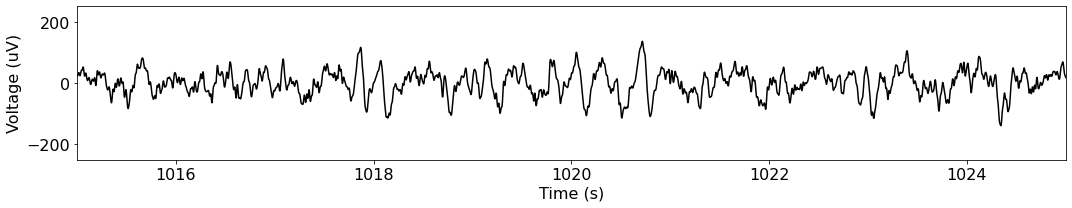

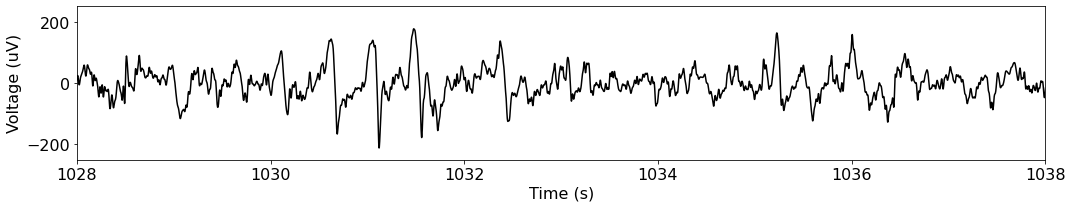

In [18]:
# Plot a couple interesting ranges (manually tuned) 
plot_time_series(times, sig_filt, xlim=[1015, 1025], ylim=[-250, 250])
plot_time_series(times, sig_filt, xlim=[1028, 1038], ylim=[-250, 250])

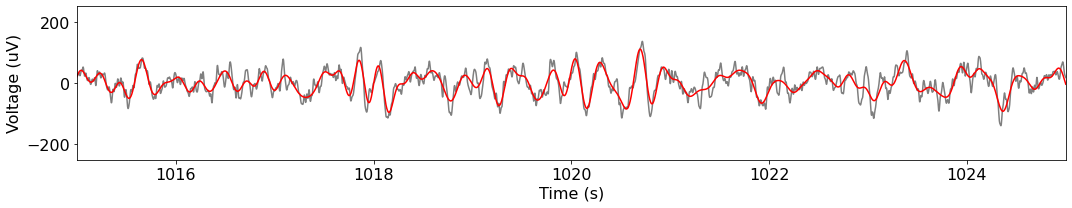

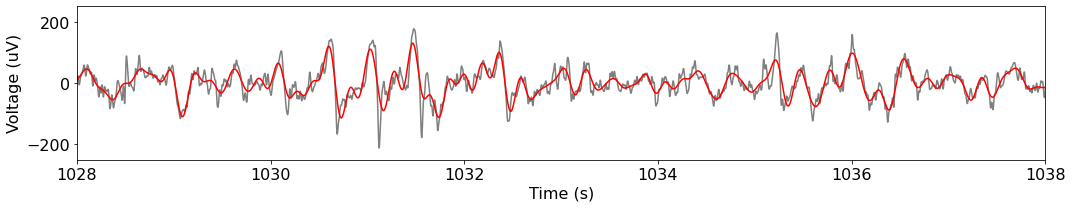

In [19]:
# Plot a the low filtered versions of the time segments from above
plot_time_series(times, [sig_filt, low_filt], alpha=[0.5, 1.],
                 xlim=[1015, 1025], ylim=[-250, 250])
plot_time_series(times, [sig_filt, low_filt], alpha=[0.5, 1],
                 xlim=[1028, 1038], ylim=[-250, 250])

### Relate Spiking to Field Data

In [20]:
# Pull out all the spike times from NWB file
spike_times = nwbfile.units.spike_times

In [21]:
# Grab spikes for requested unit
uind = 5
unit_spikes = nwbfile.units.get_unit_spike_times(uind)

In [22]:
# Get spike times for time ranges of interest, from above
time_spikes1 = get_spike_time_range(unit_spikes, 1015 * 1000, 1025 * 1000) / 1000
time_spikes2 = get_spike_time_range(unit_spikes, 1028 * 1000, 1038 * 1000) / 1000

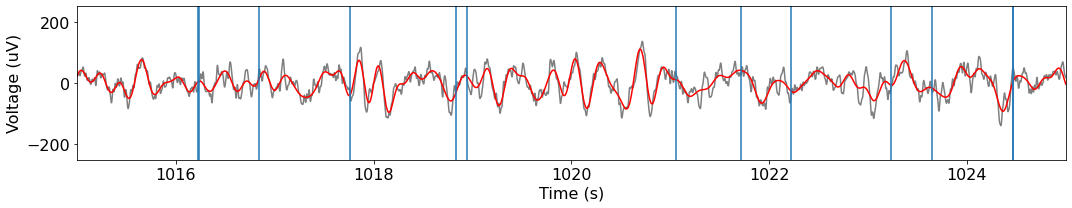

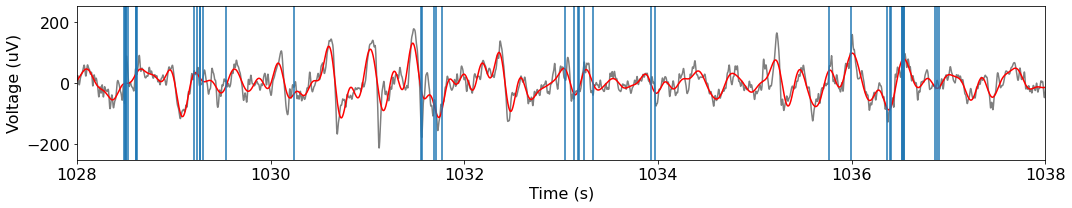

In [23]:
# Plot field data, with overlying spike times
plot_time_series(times, [sig_filt, low_filt], alpha=[0.5, 1.],
                 xlim=[1015, 1025], ylim=[-250, 250])
for spike in time_spikes1:
    plt.gca().axvline(spike)
    
plot_time_series(times, [sig_filt, low_filt], alpha=[0.5, 1.],
                 xlim=[1028, 1038], ylim=[-250, 250])
for spike in time_spikes2:
    plt.gca().axvline(spike)

### Instantaneous Measures

In [24]:
# Calculate instantaneous amplitude across the whole signal
amps = amp_by_time(low_filt, fs)

In [25]:
# Calculate instantaneous phasesacross the whole signal
phases = phase_by_time(low_filt, fs)

In [26]:
import math

def find_nearest(array, value):
    """Find nearest index to a requested value in an array.
    Note: implementation from https://stackoverflow.com/a/26026189
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
def get_time_vals(times, values, timepoints):
    """Get values from an array for specific time points."""
    
    out = np.zeros(len(timepoints))
    for ind, timepoint in enumerate(timepoints):
        out[ind] = values[find_nearest(times, timepoint)]

    return out

#### Distribution of amplitude at spike times

In [27]:
# Grab the analytic amplitudes at spike times
amp_vals = get_time_vals(times, amps, spike_times[:]/1000)

(0.0, 4.0)

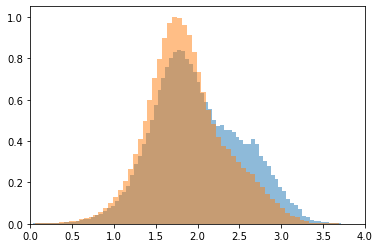

In [28]:
# Plot the d
plt.hist(np.log10(amp_vals), density=True, bins=100, alpha=0.5);
plt.hist(np.log10(amps), density=True, bins=100, alpha=0.5);
plt.xlim([0, 4])

Note in the above: it appears the amplitude values with an oscillation oversample high-amplitude values.

However, it might just be that this is an artifact of looking at time points with spikes present. 

#### Distribution of phases at spike times

In [29]:
# Grab the analytic phases at spike times
pha_vals = get_time_vals(times, phases, spike_times[:]/1000)

In [30]:
# Compute histogram binning of all phase values
all_phase_counts, all_phase_bins = np.histogram(phases[~np.isnan(phases)], bins=25, density=True)

# Compute histogram binning of spike-time phase values
spike_phase_counts, spike_phase_bins = np.histogram(pha_vals[~np.isnan(pha_vals)], bins=25, density=True)

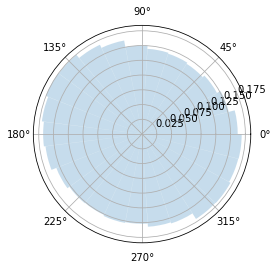

In [31]:
# Plot histogram of spike-time phase values
ax = plt.subplot(111, projection='polar')
bars = ax.bar(spike_phase_bins[:-1], spike_phase_counts, width=0.25, alpha=0.25)

Note in the above: it appears that the phase distribution is somewhat non-uniform, suggesting a slight tendency for spikes to occure at particular phases. 